In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'
    %%capture output

Mounted at /content/drive


## Imports

In [2]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Fri May 26 02:51:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the CIFAR Dataset

In [3]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_data_train = datasets.CIFAR10('../data/cifar10/', train=True, download=True, transform=transform_train)
cifar_data_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:04<00:00, 37198695.47it/s]


Extracting ../data/cifar10/cifar-10-python.tar.gz to ../data/cifar10/
Files already downloaded and verified


In [4]:
classes = np.array(list(cifar_data_train.class_to_idx.values()))
classes_test = np.array(list(cifar_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [5]:
print("Image Shape: {}".format(cifar_data_train.data[0].shape))

Image Shape: (32, 32, 3)


## Visualize Data

In [6]:
def imshow(img):
	#img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='hsv') # convert from tensor to image

In [7]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    #data = data.numpy()

    target = dataset.targets[i]
    #target = target.numpy()
    imshow(data)
    axis.set_title(target)


## Partitioning the Data (IID and non-IID)

In [9]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the CIFAR Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [10]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the CIFAR Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = np.array(dataset.targets)

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [11]:
class CIFAR_MLP(nn.Module):
  def __init__(self):
    super(CIFAR_MLP, self).__init__()
    self.fc1 = nn.Linear(3 * 32 * 32, 2634)
    self.fc2 = nn.Linear(2634, 2196) 
    self.fc3 = nn.Linear(2196, 1758)
    self.fc4 = nn.Linear(1758, 1320)
    self.fc5 = nn.Linear(1320, 882)
    self.fc6 = nn.Linear(882, 444) 
    self.fc7 = nn.Linear(444, 10) 

  def forward(self, x):
    x = x.view(-1, 3 * 32 * 32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))

    x = self.fc7(x)
    return x

In [12]:
class CIFAR_CNN(nn.Module):
  def __init__(self):
    super(CIFAR_CNN, self).__init__()

    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),)
    self.fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(4096, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, 10))
  def forward(self, x):      
    x = self.conv_layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x

### Print Model Summaries

In [13]:
cifar_mlp = CIFAR_MLP()
cifar_cnn = CIFAR_CNN()

if torch.cuda.is_available():
  cifar_mlp.cuda()
  cifar_cnn.cuda()

print("CIFAR MLP SUMMARY")
print(summary(cifar_mlp, (32,32,3)))

print("\nCIFAR CNN SUMMARY")
print(summary(cifar_cnn, (3, 32,32)))

CIFAR MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2634]       8,094,282
            Linear-2                 [-1, 2196]       5,786,460
            Linear-3                 [-1, 1758]       3,862,326
            Linear-4                 [-1, 1320]       2,321,880
            Linear-5                  [-1, 882]       1,165,122
            Linear-6                  [-1, 444]         392,052
            Linear-7                   [-1, 10]           4,450
Total params: 21,626,572
Trainable params: 21,626,572
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 82.50
Estimated Total Size (MB): 82.58
----------------------------------------------------------------
None

CIFAR CNN SUMMARY
--------------------------------------------------------

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [14]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0
      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [15]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []


  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()
  
  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end-start))
  
  return model, train_loss, test_accuracy, test_loss

## Testing Loop

In [16]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))
  
  return test_accuracy, test_loss

## Logger

In [17]:
log_dict = {}
NUM_REPEAT = 5

## CIFAR CNN on IID

### Train


Experiment Run Number:  0
Round: 1... 	Average Loss: 2.283
Round: 2... 	Average Loss: 2.203
Round: 3... 	Average Loss: 2.132
Round: 4... 	Average Loss: 2.07
Round: 5... 	Average Loss: 2.031
Round: 6... 	Average Loss: 2.006
Round: 7... 	Average Loss: 1.97
Round: 8... 	Average Loss: 1.944
Round: 9... 	Average Loss: 1.94
Round: 10... 	Average Loss: 1.893
Round: 11... 	Average Loss: 1.883
Round: 12... 	Average Loss: 1.875
Round: 13... 	Average Loss: 1.852
Round: 14... 	Average Loss: 1.828
Round: 15... 	Average Loss: 1.797
Round: 16... 	Average Loss: 1.797
Round: 17... 	Average Loss: 1.766
Round: 18... 	Average Loss: 1.764
Round: 19... 	Average Loss: 1.718
Round: 20... 	Average Loss: 1.733
Round: 21... 	Average Loss: 1.704
Round: 22... 	Average Loss: 1.702
Round: 23... 	Average Loss: 1.692
Round: 24... 	Average Loss: 1.664
Round: 25... 	Average Loss: 1.656
Round: 26... 	Average Loss: 1.632
Round: 27... 	Average Loss: 1.622
Round: 28... 	Average Loss: 1.634
Round: 29... 	Average Loss: 1.594


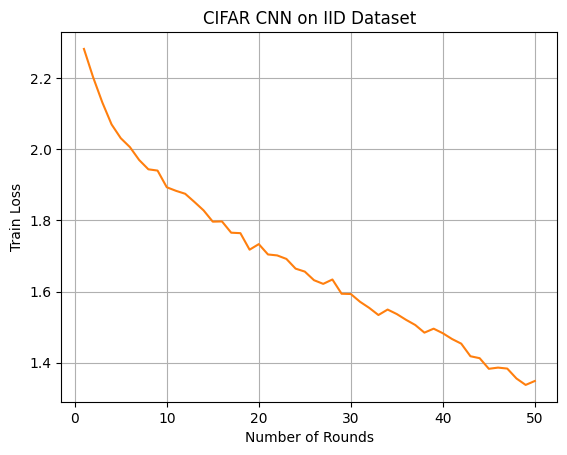

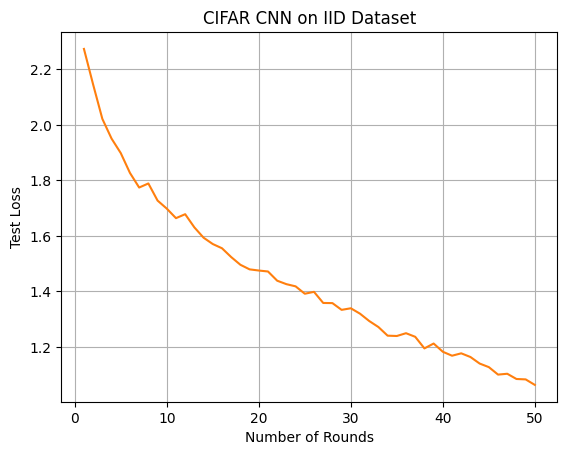

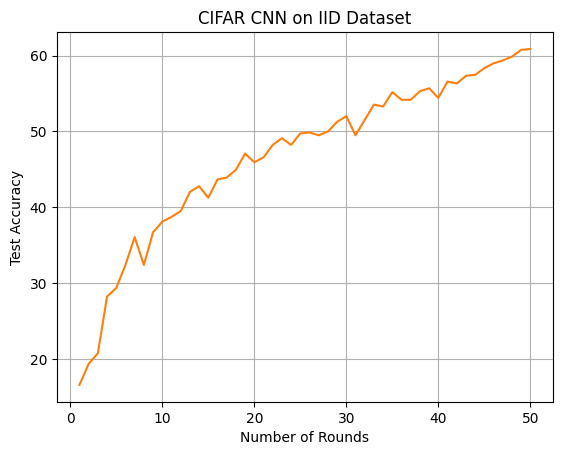

Training Done!
Total time taken to Train: 437.8717119693756


Experiment Run Number:  1
Round: 1... 	Average Loss: 2.262
Round: 2... 	Average Loss: 2.169
Round: 3... 	Average Loss: 2.122
Round: 4... 	Average Loss: 2.068
Round: 5... 	Average Loss: 2.048
Round: 6... 	Average Loss: 2.007
Round: 7... 	Average Loss: 1.971
Round: 8... 	Average Loss: 1.955
Round: 9... 	Average Loss: 1.916
Round: 10... 	Average Loss: 1.91
Round: 11... 	Average Loss: 1.882
Round: 12... 	Average Loss: 1.875
Round: 13... 	Average Loss: 1.844
Round: 14... 	Average Loss: 1.82
Round: 15... 	Average Loss: 1.792
Round: 16... 	Average Loss: 1.795
Round: 17... 	Average Loss: 1.776
Round: 18... 	Average Loss: 1.737
Round: 19... 	Average Loss: 1.726
Round: 20... 	Average Loss: 1.746
Round: 21... 	Average Loss: 1.71
Round: 22... 	Average Loss: 1.7
Round: 23... 	Average Loss: 1.677
Round: 24... 	Average Loss: 1.655
Round: 25... 	Average Loss: 1.671
Round: 26... 	Average Loss: 1.615
Round: 27... 	Average Loss: 1.625
Round: 2

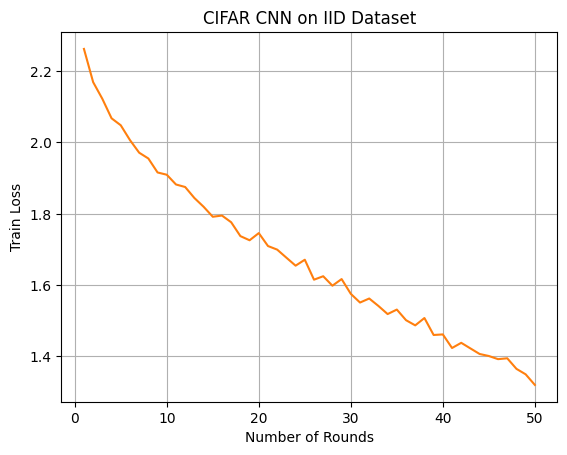

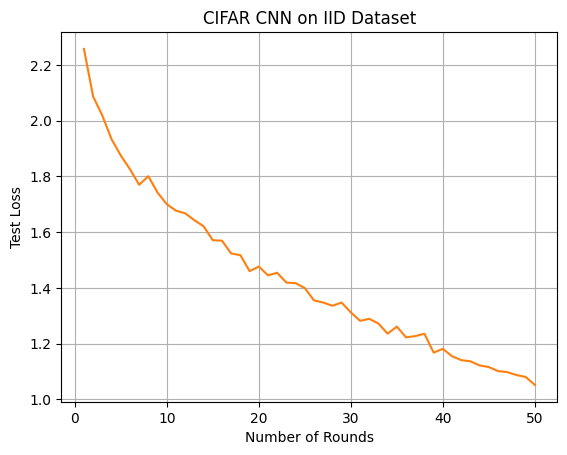

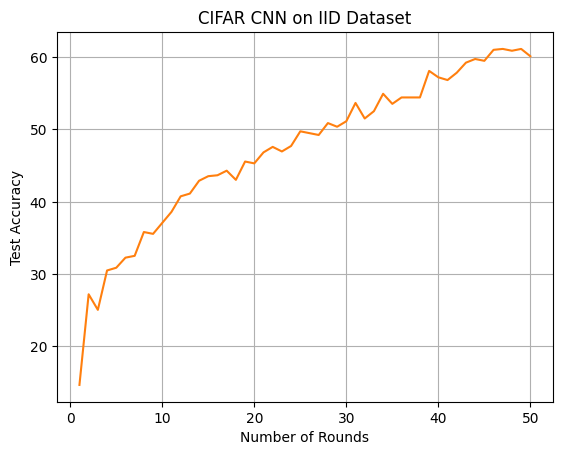

Training Done!
Total time taken to Train: 433.2611961364746


Experiment Run Number:  2
Round: 1... 	Average Loss: 2.267
Round: 2... 	Average Loss: 2.169
Round: 3... 	Average Loss: 2.106
Round: 4... 	Average Loss: 2.063
Round: 5... 	Average Loss: 2.053
Round: 6... 	Average Loss: 1.979
Round: 7... 	Average Loss: 1.967
Round: 8... 	Average Loss: 1.93
Round: 9... 	Average Loss: 1.914
Round: 10... 	Average Loss: 1.9
Round: 11... 	Average Loss: 1.887
Round: 12... 	Average Loss: 1.853
Round: 13... 	Average Loss: 1.847
Round: 14... 	Average Loss: 1.829
Round: 15... 	Average Loss: 1.798
Round: 16... 	Average Loss: 1.795
Round: 17... 	Average Loss: 1.775
Round: 18... 	Average Loss: 1.753
Round: 19... 	Average Loss: 1.756
Round: 20... 	Average Loss: 1.72
Round: 21... 	Average Loss: 1.715
Round: 22... 	Average Loss: 1.686
Round: 23... 	Average Loss: 1.672
Round: 24... 	Average Loss: 1.667
Round: 25... 	Average Loss: 1.66
Round: 26... 	Average Loss: 1.637
Round: 27... 	Average Loss: 1.607
Round: 2

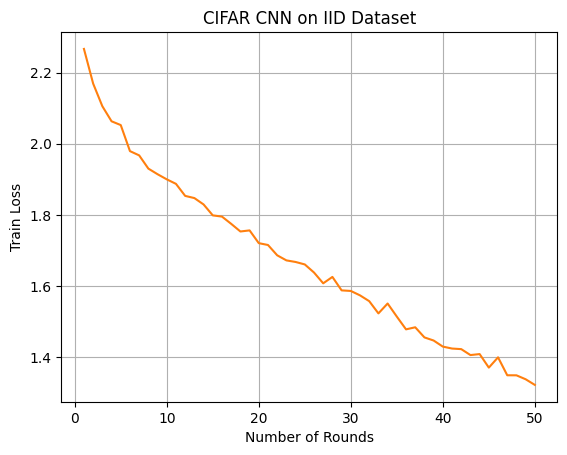

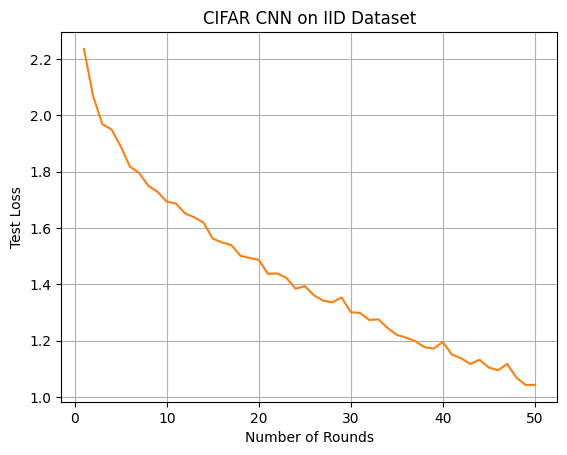

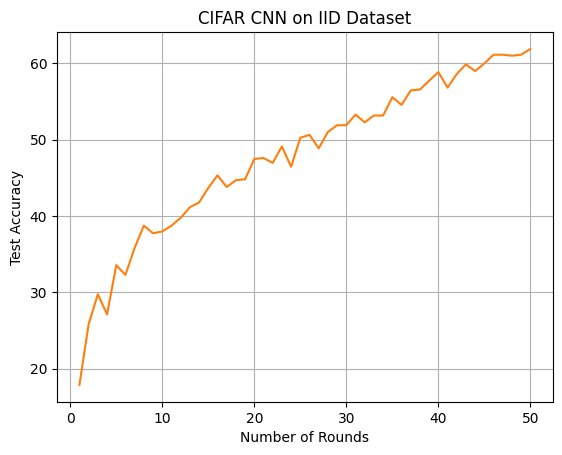

Training Done!
Total time taken to Train: 433.06384563446045


Experiment Run Number:  3
Round: 1... 	Average Loss: 2.272
Round: 2... 	Average Loss: 2.178
Round: 3... 	Average Loss: 2.106
Round: 4... 	Average Loss: 2.068
Round: 5... 	Average Loss: 2.038
Round: 6... 	Average Loss: 2.006
Round: 7... 	Average Loss: 1.973
Round: 8... 	Average Loss: 1.97
Round: 9... 	Average Loss: 1.927
Round: 10... 	Average Loss: 1.912
Round: 11... 	Average Loss: 1.89
Round: 12... 	Average Loss: 1.883
Round: 13... 	Average Loss: 1.84
Round: 14... 	Average Loss: 1.826
Round: 15... 	Average Loss: 1.815
Round: 16... 	Average Loss: 1.779
Round: 17... 	Average Loss: 1.787
Round: 18... 	Average Loss: 1.755
Round: 19... 	Average Loss: 1.743
Round: 20... 	Average Loss: 1.722
Round: 21... 	Average Loss: 1.692
Round: 22... 	Average Loss: 1.69
Round: 23... 	Average Loss: 1.684
Round: 24... 	Average Loss: 1.681
Round: 25... 	Average Loss: 1.639
Round: 26... 	Average Loss: 1.634
Round: 27... 	Average Loss: 1.601
Round:

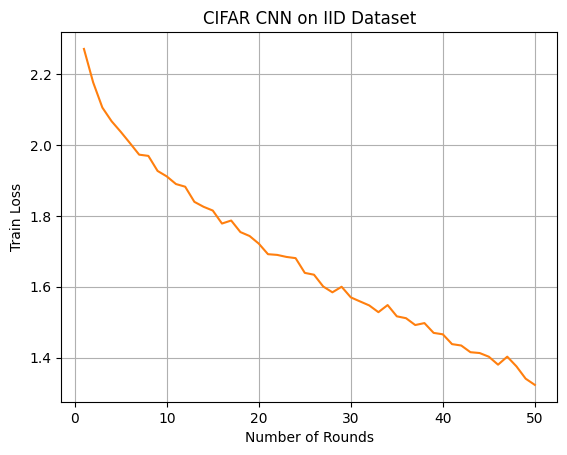

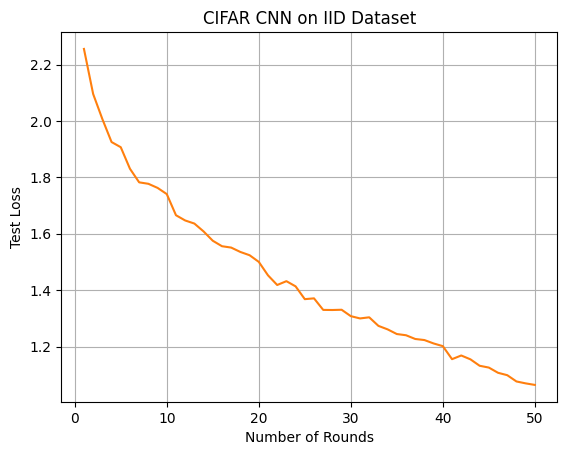

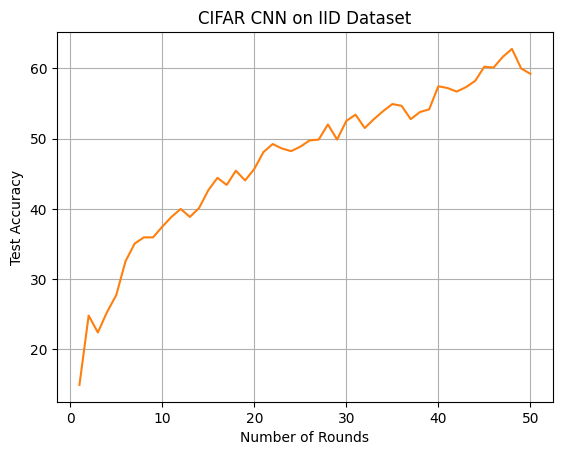

Training Done!
Total time taken to Train: 434.51395535469055


Experiment Run Number:  4
Round: 1... 	Average Loss: 2.259
Round: 2... 	Average Loss: 2.171
Round: 3... 	Average Loss: 2.098
Round: 4... 	Average Loss: 2.079
Round: 5... 	Average Loss: 2.047
Round: 6... 	Average Loss: 2.005
Round: 7... 	Average Loss: 1.965
Round: 8... 	Average Loss: 1.962
Round: 9... 	Average Loss: 1.931
Round: 10... 	Average Loss: 1.903
Round: 11... 	Average Loss: 1.874
Round: 12... 	Average Loss: 1.884
Round: 13... 	Average Loss: 1.843
Round: 14... 	Average Loss: 1.813
Round: 15... 	Average Loss: 1.817
Round: 16... 	Average Loss: 1.777
Round: 17... 	Average Loss: 1.793
Round: 18... 	Average Loss: 1.758
Round: 19... 	Average Loss: 1.739
Round: 20... 	Average Loss: 1.699
Round: 21... 	Average Loss: 1.724
Round: 22... 	Average Loss: 1.687
Round: 23... 	Average Loss: 1.672
Round: 24... 	Average Loss: 1.639
Round: 25... 	Average Loss: 1.639
Round: 26... 	Average Loss: 1.619
Round: 27... 	Average Loss: 1.628
Ro

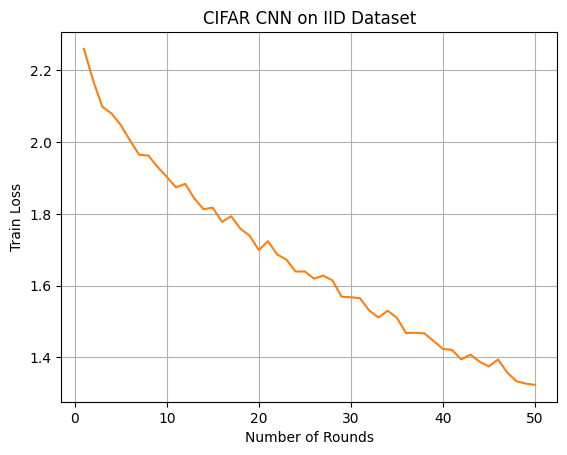

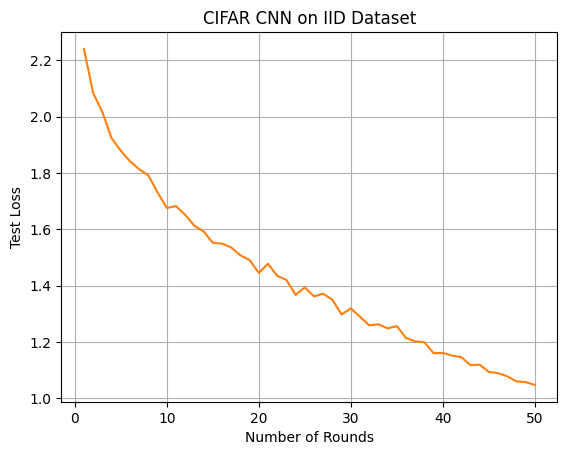

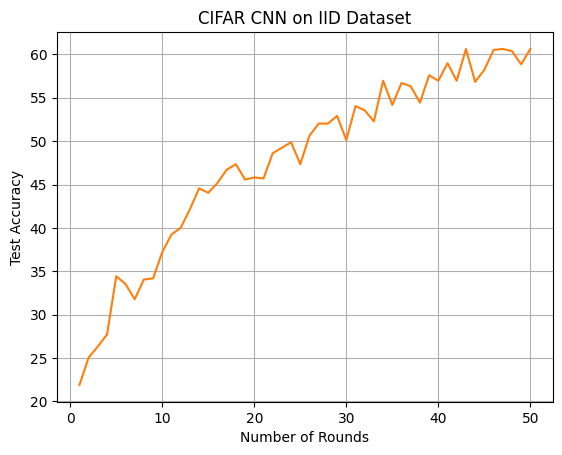

Training Done!
Total time taken to Train: 431.99702620506287




In [18]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # data partition dictionary
  iid_dict = iid_partition(cifar_data_train, 100)
  # load model
  cifar_cnn = CIFAR_CNN()

  if torch.cuda.is_available():
    cifar_cnn.cuda()

  cifar_cnn_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_cnn, rounds, batch_size, lr, cifar_data_train, cifar_data_test, iid_dict, C, K, E, "CIFAR CNN on IID Dataset", "orange")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [19]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(cifar_cnn_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 1.046806

Test Accuracy of     0: 56% (41/72)
Test Accuracy of     1: 83% (65/78)
Test Accuracy of     2: 42% (37/87)
Test Accuracy of     3: 23% (19/80)
Test Accuracy of     4: 52% (38/72)
Test Accuracy of     5: 61% (45/73)
Test Accuracy of     6: 79% (71/89)
Test Accuracy of     7: 58% (46/78)
Test Accuracy of     8: 82% (71/86)
Test Accuracy of     9: 61% (46/75)

Final Test  Accuracy: 60.633 (479.0/790.0)


## CIFAR CNN on Non IID

### Train


Experiment Run Number:  0
Round: 1... 	Average Loss: 0.841
Round: 2... 	Average Loss: 0.933
Round: 3... 	Average Loss: 0.666
Round: 4... 	Average Loss: 0.707
Round: 5... 	Average Loss: 0.792
Round: 6... 	Average Loss: 0.652
Round: 7... 	Average Loss: 0.746
Round: 8... 	Average Loss: 0.724
Round: 9... 	Average Loss: 0.647
Round: 10... 	Average Loss: 0.705
Round: 11... 	Average Loss: 0.656
Round: 12... 	Average Loss: 0.509
Round: 13... 	Average Loss: 0.51
Round: 14... 	Average Loss: 0.591
Round: 15... 	Average Loss: 0.581
Round: 16... 	Average Loss: 0.469
Round: 17... 	Average Loss: 0.554
Round: 18... 	Average Loss: 0.659
Round: 19... 	Average Loss: 0.652
Round: 20... 	Average Loss: 0.666
Round: 21... 	Average Loss: 0.585
Round: 22... 	Average Loss: 0.527
Round: 23... 	Average Loss: 0.486
Round: 24... 	Average Loss: 0.57
Round: 25... 	Average Loss: 0.637
Round: 26... 	Average Loss: 0.699
Round: 27... 	Average Loss: 0.584
Round: 28... 	Average Loss: 0.603
Round: 29... 	Average Loss: 0.588

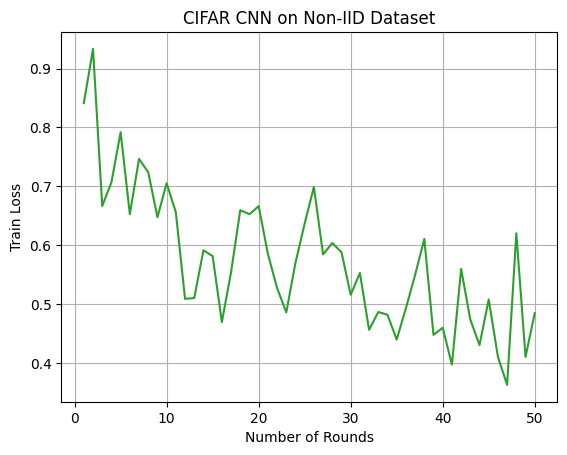

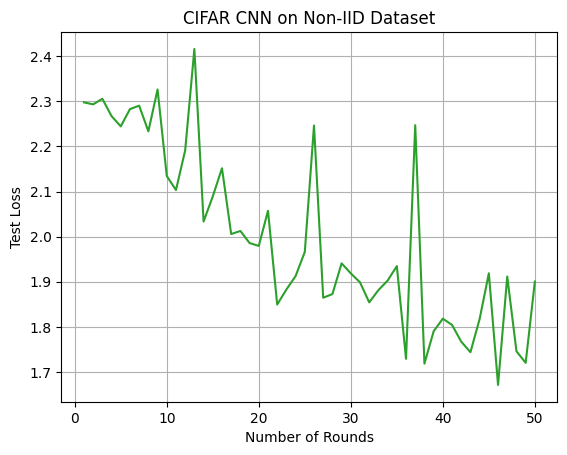

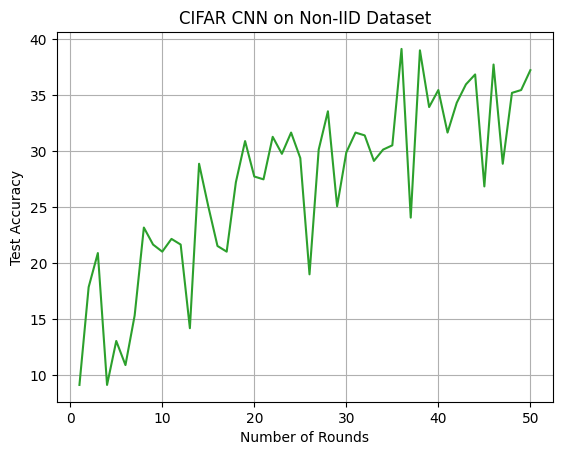

Training Done!
Total time taken to Train: 431.63565135002136


Experiment Run Number:  1
Round: 1... 	Average Loss: 1.05
Round: 2... 	Average Loss: 0.929
Round: 3... 	Average Loss: 0.707
Round: 4... 	Average Loss: 0.563
Round: 5... 	Average Loss: 0.8
Round: 6... 	Average Loss: 0.65
Round: 7... 	Average Loss: 0.695
Round: 8... 	Average Loss: 0.68
Round: 9... 	Average Loss: 0.62
Round: 10... 	Average Loss: 0.749
Round: 11... 	Average Loss: 0.584
Round: 12... 	Average Loss: 0.639
Round: 13... 	Average Loss: 0.64
Round: 14... 	Average Loss: 0.556
Round: 15... 	Average Loss: 0.548
Round: 16... 	Average Loss: 0.614
Round: 17... 	Average Loss: 0.514
Round: 18... 	Average Loss: 0.562
Round: 19... 	Average Loss: 0.653
Round: 20... 	Average Loss: 0.604
Round: 21... 	Average Loss: 0.505
Round: 22... 	Average Loss: 0.772
Round: 23... 	Average Loss: 0.543
Round: 24... 	Average Loss: 0.446
Round: 25... 	Average Loss: 0.637
Round: 26... 	Average Loss: 0.446
Round: 27... 	Average Loss: 0.44
Round: 28.

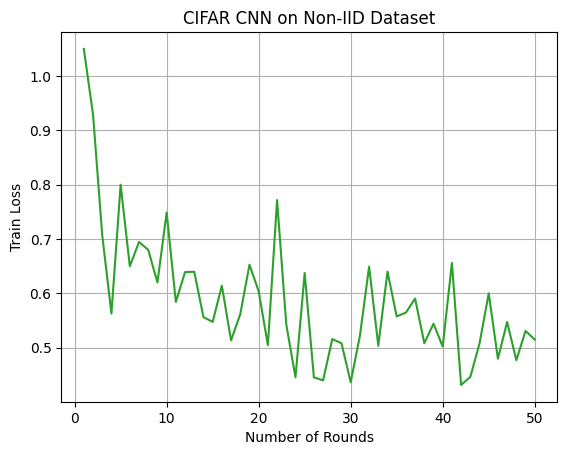

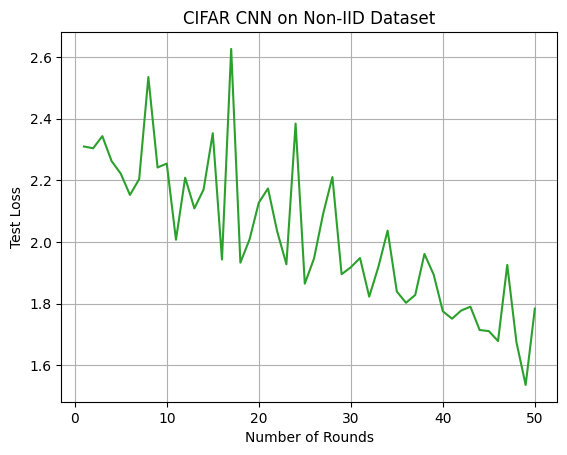

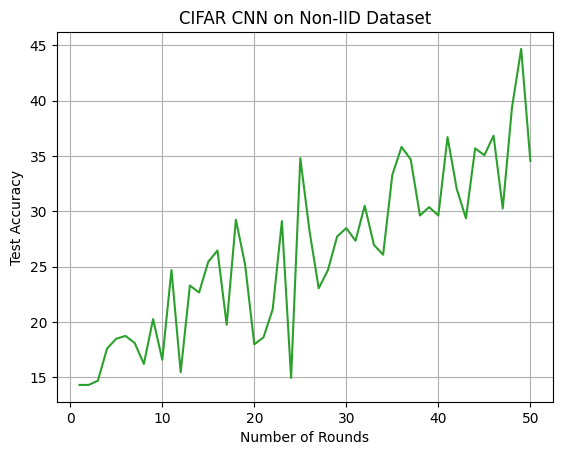

Training Done!
Total time taken to Train: 434.45114254951477


Experiment Run Number:  2
Round: 1... 	Average Loss: 0.992
Round: 2... 	Average Loss: 0.982
Round: 3... 	Average Loss: 0.822
Round: 4... 	Average Loss: 0.82
Round: 5... 	Average Loss: 0.856
Round: 6... 	Average Loss: 0.771
Round: 7... 	Average Loss: 0.687
Round: 8... 	Average Loss: 0.666
Round: 9... 	Average Loss: 0.602
Round: 10... 	Average Loss: 0.743
Round: 11... 	Average Loss: 0.658
Round: 12... 	Average Loss: 0.63
Round: 13... 	Average Loss: 0.677
Round: 14... 	Average Loss: 0.637
Round: 15... 	Average Loss: 0.59
Round: 16... 	Average Loss: 0.764
Round: 17... 	Average Loss: 0.627
Round: 18... 	Average Loss: 0.61
Round: 19... 	Average Loss: 0.425
Round: 20... 	Average Loss: 0.61
Round: 21... 	Average Loss: 0.509
Round: 22... 	Average Loss: 0.545
Round: 23... 	Average Loss: 0.594
Round: 24... 	Average Loss: 0.438
Round: 25... 	Average Loss: 0.607
Round: 26... 	Average Loss: 0.539
Round: 27... 	Average Loss: 0.608
Round: 

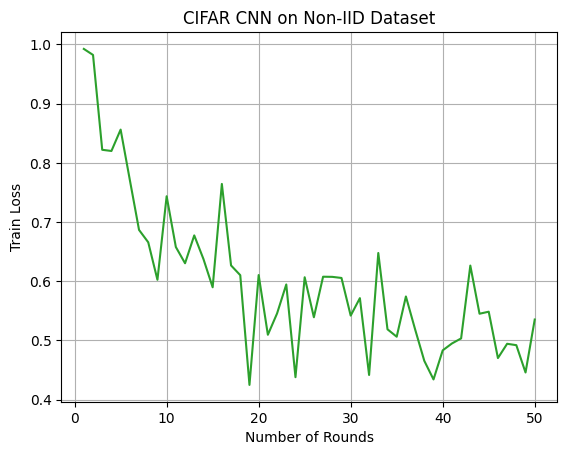

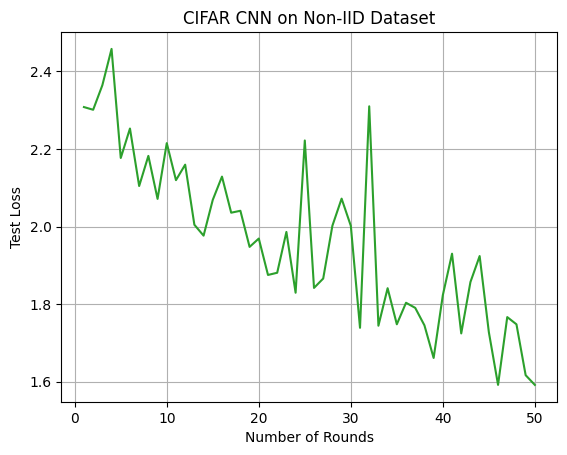

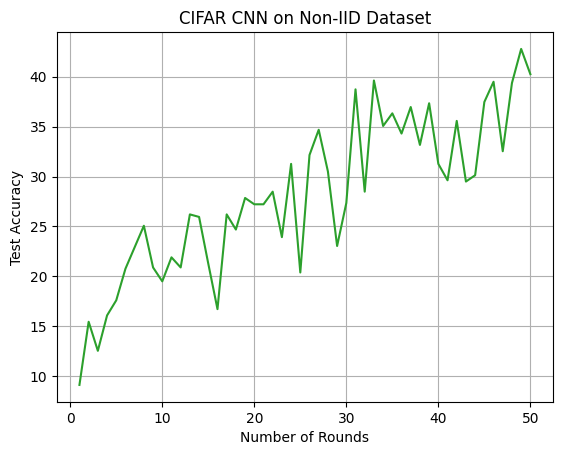

Training Done!
Total time taken to Train: 430.8199679851532


Experiment Run Number:  3
Round: 1... 	Average Loss: 1.042
Round: 2... 	Average Loss: 0.94
Round: 3... 	Average Loss: 0.756
Round: 4... 	Average Loss: 0.772
Round: 5... 	Average Loss: 0.705
Round: 6... 	Average Loss: 0.594
Round: 7... 	Average Loss: 0.661
Round: 8... 	Average Loss: 0.677
Round: 9... 	Average Loss: 0.68
Round: 10... 	Average Loss: 0.727
Round: 11... 	Average Loss: 0.722
Round: 12... 	Average Loss: 0.733
Round: 13... 	Average Loss: 0.633
Round: 14... 	Average Loss: 0.567
Round: 15... 	Average Loss: 0.609
Round: 16... 	Average Loss: 0.584
Round: 17... 	Average Loss: 0.632
Round: 18... 	Average Loss: 0.466
Round: 19... 	Average Loss: 0.507
Round: 20... 	Average Loss: 0.59
Round: 21... 	Average Loss: 0.525
Round: 22... 	Average Loss: 0.404
Round: 23... 	Average Loss: 0.591
Round: 24... 	Average Loss: 0.403
Round: 25... 	Average Loss: 0.452
Round: 26... 	Average Loss: 0.633
Round: 27... 	Average Loss: 0.419
Round:

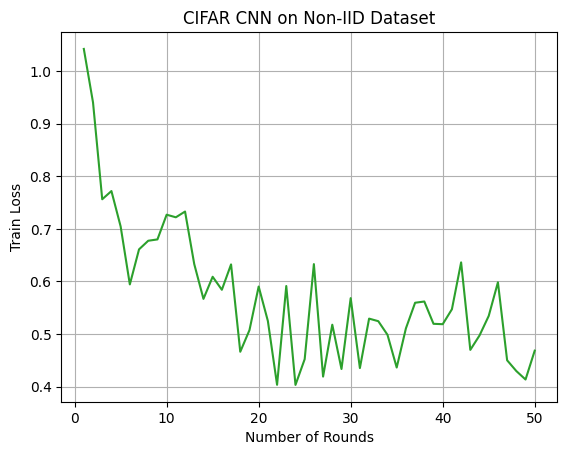

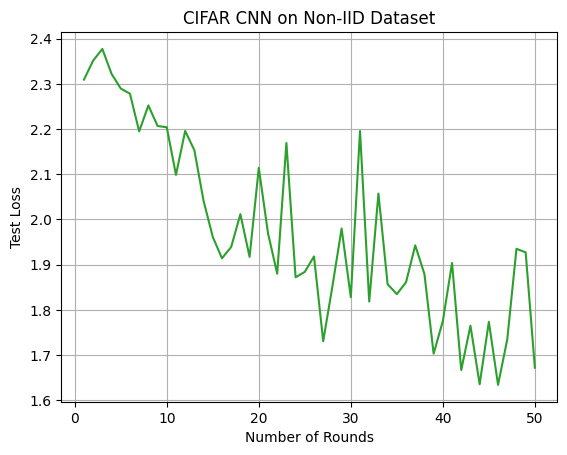

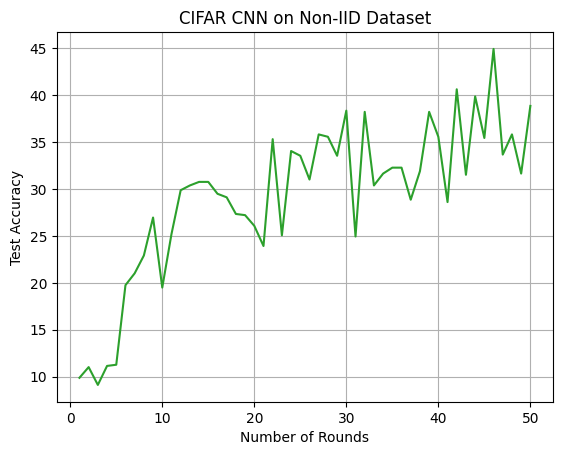

Training Done!
Total time taken to Train: 431.4485309123993


Experiment Run Number:  4
Round: 1... 	Average Loss: 1.009
Round: 2... 	Average Loss: 0.861
Round: 3... 	Average Loss: 0.819
Round: 4... 	Average Loss: 0.779
Round: 5... 	Average Loss: 0.801
Round: 6... 	Average Loss: 0.706
Round: 7... 	Average Loss: 0.731
Round: 8... 	Average Loss: 0.81
Round: 9... 	Average Loss: 0.749
Round: 10... 	Average Loss: 0.721
Round: 11... 	Average Loss: 0.72
Round: 12... 	Average Loss: 0.577
Round: 13... 	Average Loss: 0.636
Round: 14... 	Average Loss: 0.625
Round: 15... 	Average Loss: 0.602
Round: 16... 	Average Loss: 0.71
Round: 17... 	Average Loss: 0.639
Round: 18... 	Average Loss: 0.667
Round: 19... 	Average Loss: 0.463
Round: 20... 	Average Loss: 0.613
Round: 21... 	Average Loss: 0.672
Round: 22... 	Average Loss: 0.546
Round: 23... 	Average Loss: 0.625
Round: 24... 	Average Loss: 0.672
Round: 25... 	Average Loss: 0.67
Round: 26... 	Average Loss: 0.583
Round: 27... 	Average Loss: 0.499
Round: 

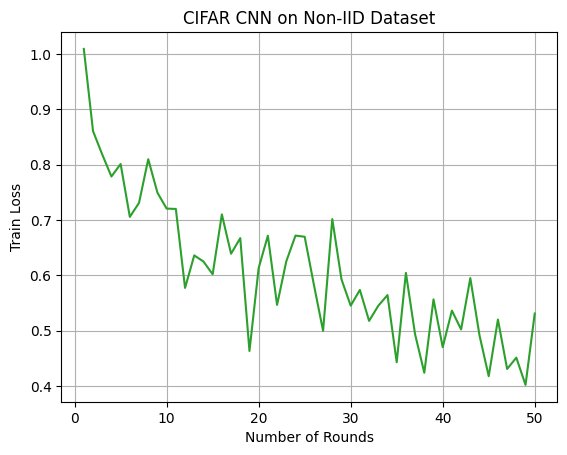

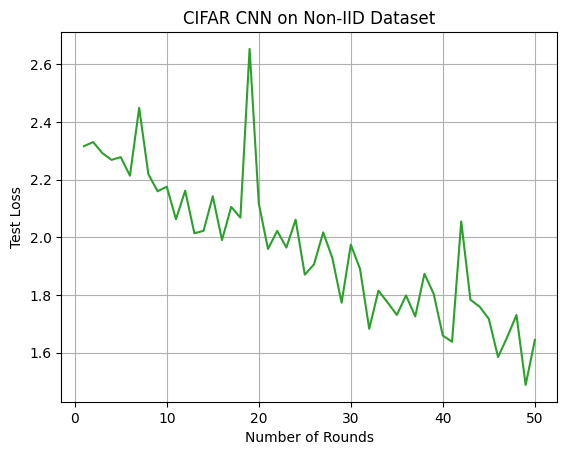

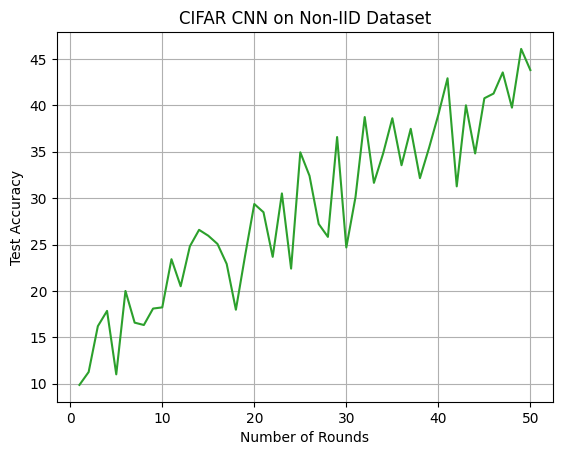

Training Done!
Total time taken to Train: 429.4621798992157




In [21]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(cifar_data_train, 100, 200, 250, 2)
  # load model
  cifar_cnn = CIFAR_CNN()

  if torch.cuda.is_available():
    cifar_cnn.cuda()
 
  cifar_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_cnn, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, "CIFAR CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [22]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(cifar_cnn_non_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 1.643878

Test Accuracy of     0: 59% (43/72)
Test Accuracy of     1: 47% (37/78)
Test Accuracy of     2:  0% ( 0/87)
Test Accuracy of     3: 48% (39/80)
Test Accuracy of     4: 80% (58/72)
Test Accuracy of     5:  2% ( 2/73)
Test Accuracy of     6: 50% (45/89)
Test Accuracy of     7: 46% (36/78)
Test Accuracy of     8: 60% (52/86)
Test Accuracy of     9: 45% (34/75)

Final Test  Accuracy: 43.797 (346.0/790.0)


## CIFAR MLP on IID

### Train

Experiment Run Number:  0
Round: 1... 	Average Loss: 2.303
Round: 2... 	Average Loss: 2.299
Round: 3... 	Average Loss: 2.279
Round: 4... 	Average Loss: 2.2
Round: 5... 	Average Loss: 2.147
Round: 6... 	Average Loss: 2.128
Round: 7... 	Average Loss: 2.11
Round: 8... 	Average Loss: 2.083
Round: 9... 	Average Loss: 2.079
Round: 10... 	Average Loss: 2.059
Round: 11... 	Average Loss: 2.041
Round: 12... 	Average Loss: 2.03
Round: 13... 	Average Loss: 2.025
Round: 14... 	Average Loss: 2.019
Round: 15... 	Average Loss: 2.017
Round: 16... 	Average Loss: 1.992
Round: 17... 	Average Loss: 1.993
Round: 18... 	Average Loss: 2.0
Round: 19... 	Average Loss: 1.964
Round: 20... 	Average Loss: 1.96
Round: 21... 	Average Loss: 1.954
Round: 22... 	Average Loss: 1.949
Round: 23... 	Average Loss: 1.936
Round: 24... 	Average Loss: 1.946
Round: 25... 	Average Loss: 1.936
Round: 26... 	Average Loss: 1.929
Round: 27... 	Average Loss: 1.932
Round: 28... 	Average Loss: 1.901
Round: 29... 	Average Loss: 1.915
Roun

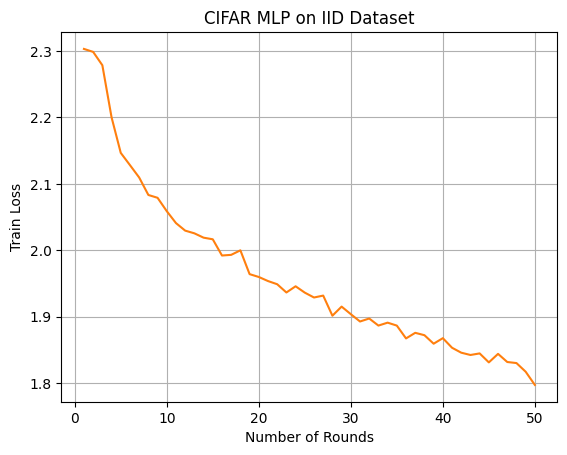

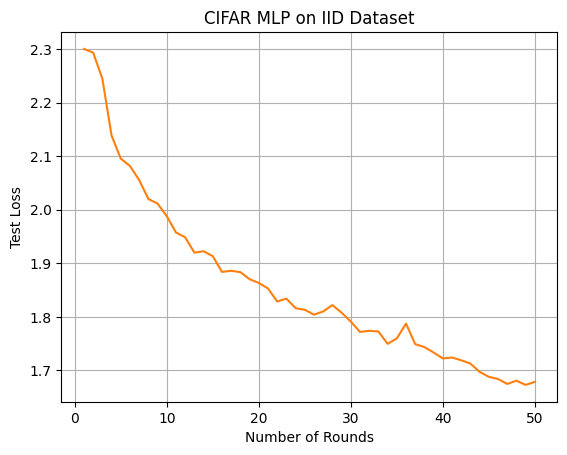

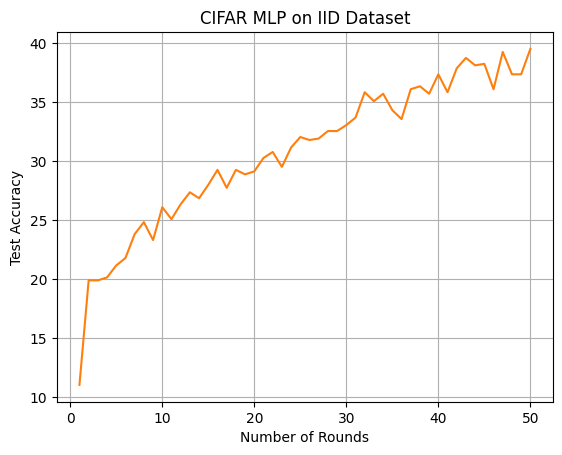

Training Done!
Total time taken to Train: 404.09338998794556


Experiment Run Number:  1
Round: 1... 	Average Loss: 2.302
Round: 2... 	Average Loss: 2.299
Round: 3... 	Average Loss: 2.275
Round: 4... 	Average Loss: 2.189
Round: 5... 	Average Loss: 2.146
Round: 6... 	Average Loss: 2.145
Round: 7... 	Average Loss: 2.117
Round: 8... 	Average Loss: 2.08
Round: 9... 	Average Loss: 2.083
Round: 10... 	Average Loss: 2.062
Round: 11... 	Average Loss: 2.04
Round: 12... 	Average Loss: 2.045
Round: 13... 	Average Loss: 2.039
Round: 14... 	Average Loss: 2.015
Round: 15... 	Average Loss: 1.996
Round: 16... 	Average Loss: 1.993
Round: 17... 	Average Loss: 1.991
Round: 18... 	Average Loss: 1.981
Round: 19... 	Average Loss: 1.978
Round: 20... 	Average Loss: 1.983
Round: 21... 	Average Loss: 1.957
Round: 22... 	Average Loss: 1.943
Round: 23... 	Average Loss: 1.938
Round: 24... 	Average Loss: 1.954
Round: 25... 	Average Loss: 1.934
Round: 26... 	Average Loss: 1.931
Round: 27... 	Average Loss: 1.911
Roun

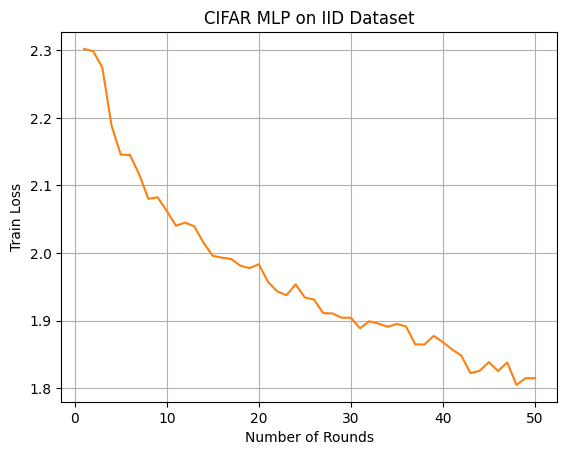

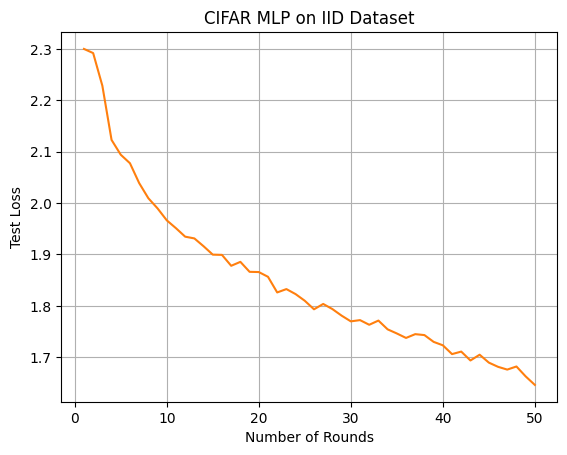

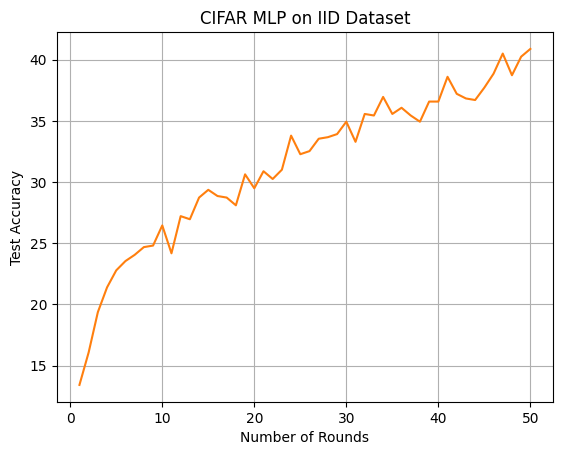

Training Done!
Total time taken to Train: 402.48619747161865


Experiment Run Number:  2
Round: 1... 	Average Loss: 2.303
Round: 2... 	Average Loss: 2.3
Round: 3... 	Average Loss: 2.286
Round: 4... 	Average Loss: 2.218
Round: 5... 	Average Loss: 2.155
Round: 6... 	Average Loss: 2.129
Round: 7... 	Average Loss: 2.1
Round: 8... 	Average Loss: 2.091
Round: 9... 	Average Loss: 2.081
Round: 10... 	Average Loss: 2.063
Round: 11... 	Average Loss: 2.043
Round: 12... 	Average Loss: 2.05
Round: 13... 	Average Loss: 2.024
Round: 14... 	Average Loss: 2.034
Round: 15... 	Average Loss: 1.999
Round: 16... 	Average Loss: 1.997
Round: 17... 	Average Loss: 1.983
Round: 18... 	Average Loss: 1.986
Round: 19... 	Average Loss: 1.964
Round: 20... 	Average Loss: 1.951
Round: 21... 	Average Loss: 1.955
Round: 22... 	Average Loss: 1.959
Round: 23... 	Average Loss: 1.945
Round: 24... 	Average Loss: 1.953
Round: 25... 	Average Loss: 1.938
Round: 26... 	Average Loss: 1.92
Round: 27... 	Average Loss: 1.926
Round: 2

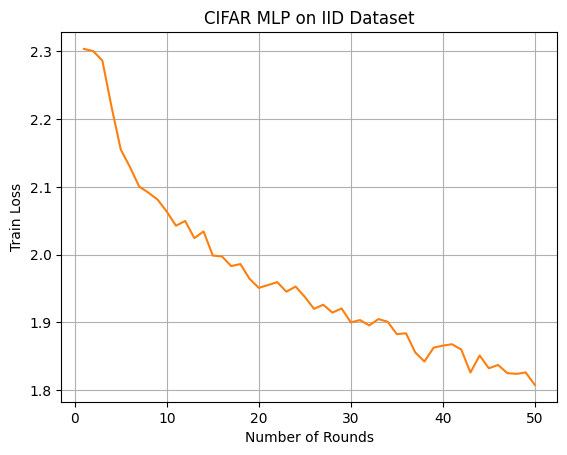

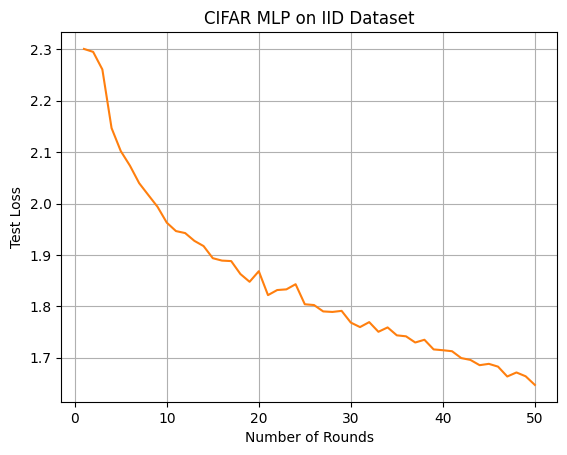

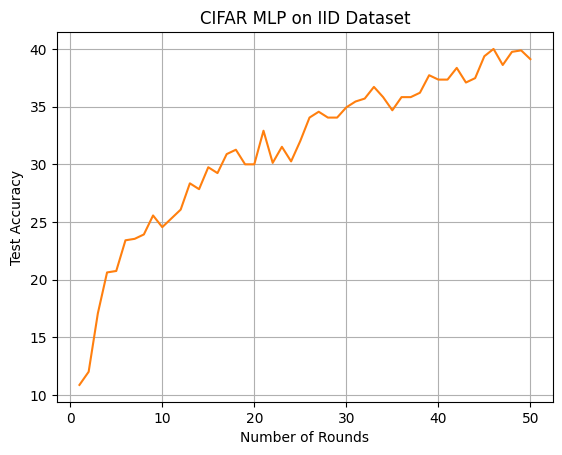

Training Done!
Total time taken to Train: 401.17691135406494


Experiment Run Number:  3
Round: 1... 	Average Loss: 2.304
Round: 2... 	Average Loss: 2.299
Round: 3... 	Average Loss: 2.28
Round: 4... 	Average Loss: 2.196
Round: 5... 	Average Loss: 2.145
Round: 6... 	Average Loss: 2.115
Round: 7... 	Average Loss: 2.099
Round: 8... 	Average Loss: 2.085
Round: 9... 	Average Loss: 2.069
Round: 10... 	Average Loss: 2.058
Round: 11... 	Average Loss: 2.047
Round: 12... 	Average Loss: 2.037
Round: 13... 	Average Loss: 2.03
Round: 14... 	Average Loss: 2.021
Round: 15... 	Average Loss: 2.012
Round: 16... 	Average Loss: 1.995
Round: 17... 	Average Loss: 1.989
Round: 18... 	Average Loss: 1.988
Round: 19... 	Average Loss: 1.974
Round: 20... 	Average Loss: 1.975
Round: 21... 	Average Loss: 1.959
Round: 22... 	Average Loss: 1.958
Round: 23... 	Average Loss: 1.947
Round: 24... 	Average Loss: 1.941
Round: 25... 	Average Loss: 1.946
Round: 26... 	Average Loss: 1.942
Round: 27... 	Average Loss: 1.912
Roun

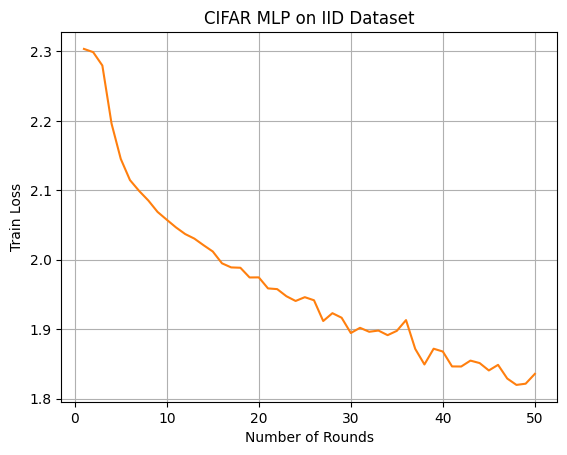

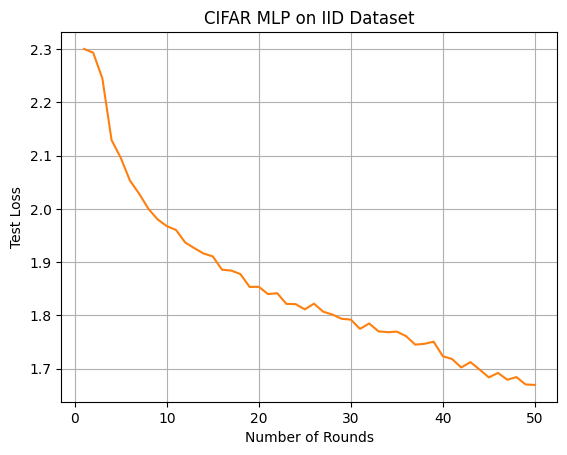

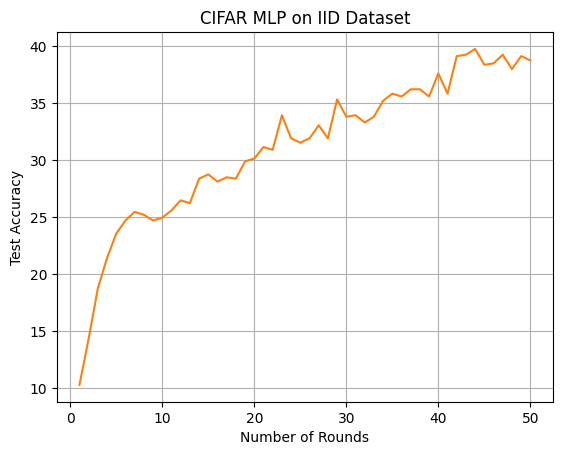

Training Done!
Total time taken to Train: 406.23278164863586


Experiment Run Number:  4
Round: 1... 	Average Loss: 2.303
Round: 2... 	Average Loss: 2.297
Round: 3... 	Average Loss: 2.272
Round: 4... 	Average Loss: 2.19
Round: 5... 	Average Loss: 2.152
Round: 6... 	Average Loss: 2.128
Round: 7... 	Average Loss: 2.118
Round: 8... 	Average Loss: 2.1
Round: 9... 	Average Loss: 2.081
Round: 10... 	Average Loss: 2.048
Round: 11... 	Average Loss: 2.05
Round: 12... 	Average Loss: 2.02
Round: 13... 	Average Loss: 2.035
Round: 14... 	Average Loss: 2.036
Round: 15... 	Average Loss: 2.018
Round: 16... 	Average Loss: 2.004
Round: 17... 	Average Loss: 1.988
Round: 18... 	Average Loss: 1.971
Round: 19... 	Average Loss: 1.968
Round: 20... 	Average Loss: 1.96
Round: 21... 	Average Loss: 1.953
Round: 22... 	Average Loss: 1.942
Round: 23... 	Average Loss: 1.938
Round: 24... 	Average Loss: 1.944
Round: 25... 	Average Loss: 1.935
Round: 26... 	Average Loss: 1.92
Round: 27... 	Average Loss: 1.92
Round: 28.

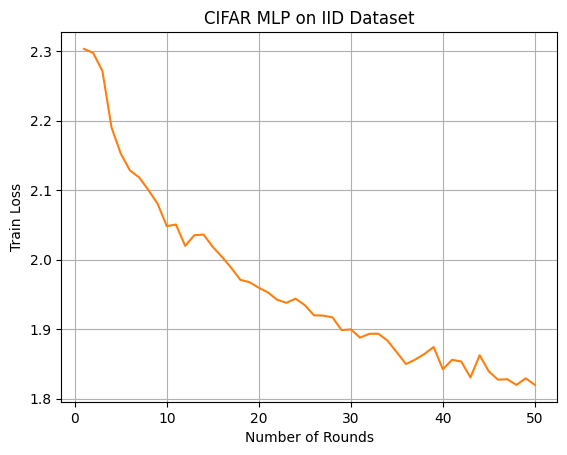

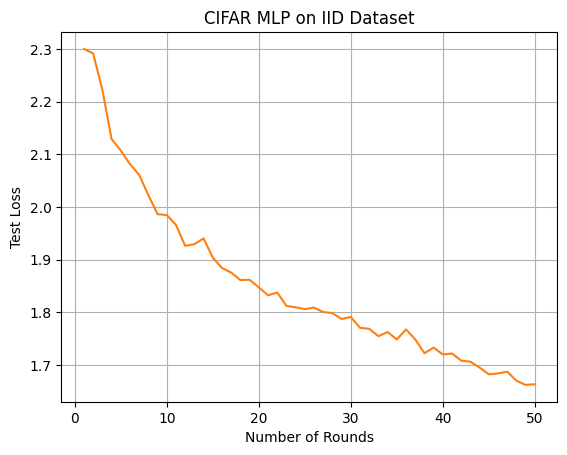

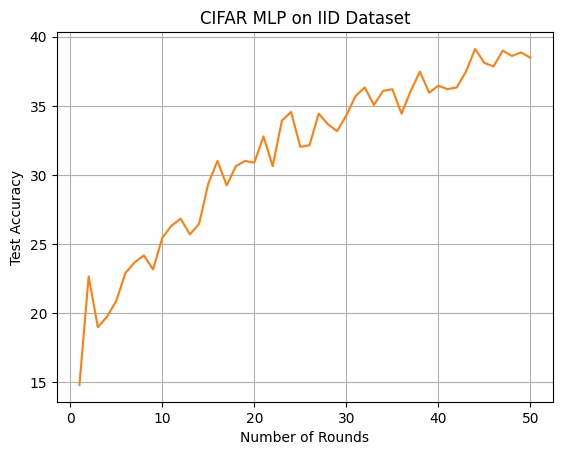

Training Done!
Total time taken to Train: 407.177264213562




In [24]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each round
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = iid_partition(cifar_data_train, 100)
  # load model
  cifar_mlp = CIFAR_MLP()

  if torch.cuda.is_available():
    cifar_mlp.cuda()

  cifar_mlp_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_mlp, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, "CIFAR MLP on IID Dataset", "orange")
  
  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [25]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(cifar_mlp_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 1.663542

Test Accuracy of     0: 34% (25/72)
Test Accuracy of     1: 60% (47/78)
Test Accuracy of     2:  2% ( 2/87)
Test Accuracy of     3: 18% (15/80)
Test Accuracy of     4: 30% (22/72)
Test Accuracy of     5: 31% (23/73)
Test Accuracy of     6: 48% (43/89)
Test Accuracy of     7: 51% (40/78)
Test Accuracy of     8: 66% (57/86)
Test Accuracy of     9: 40% (30/75)

Final Test  Accuracy: 38.481 (304.0/790.0)


## CIFAR MLP on Non IID

### Train

Experiment Run Number:  0
Round: 1... 	Average Loss: 1.133
Round: 2... 	Average Loss: 0.73
Round: 3... 	Average Loss: 0.884
Round: 4... 	Average Loss: 0.766
Round: 5... 	Average Loss: 0.704
Round: 6... 	Average Loss: 0.718
Round: 7... 	Average Loss: 0.631
Round: 8... 	Average Loss: 0.583
Round: 9... 	Average Loss: 0.642
Round: 10... 	Average Loss: 0.698
Round: 11... 	Average Loss: 0.492
Round: 12... 	Average Loss: 0.519
Round: 13... 	Average Loss: 0.679
Round: 14... 	Average Loss: 0.622
Round: 15... 	Average Loss: 0.605
Round: 16... 	Average Loss: 0.67
Round: 17... 	Average Loss: 0.643
Round: 18... 	Average Loss: 0.549
Round: 19... 	Average Loss: 0.63
Round: 20... 	Average Loss: 0.42
Round: 21... 	Average Loss: 0.731
Round: 22... 	Average Loss: 0.585
Round: 23... 	Average Loss: 0.623
Round: 24... 	Average Loss: 0.551
Round: 25... 	Average Loss: 0.599
Round: 26... 	Average Loss: 0.654
Round: 27... 	Average Loss: 0.579
Round: 28... 	Average Loss: 0.594
Round: 29... 	Average Loss: 0.617
R

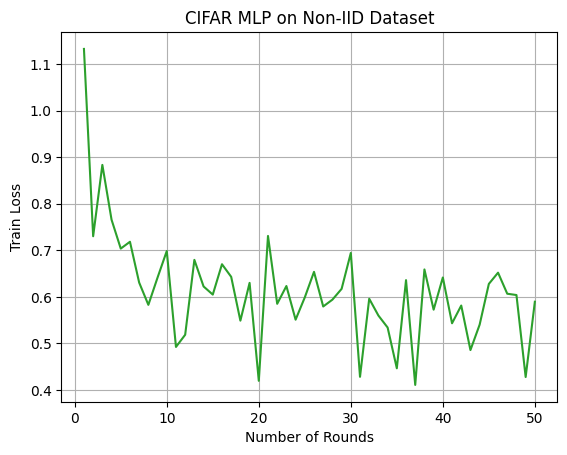

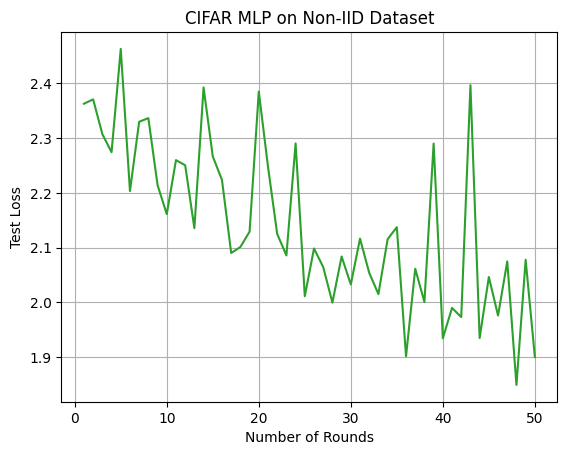

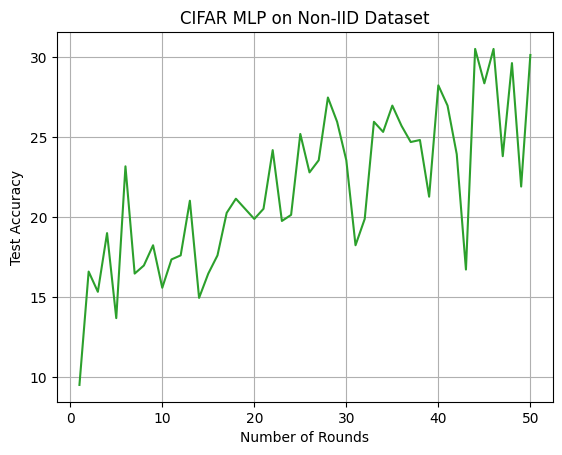

Training Done!
Total time taken to Train: 403.3817162513733


Experiment Run Number:  1
Round: 1... 	Average Loss: 1.164
Round: 2... 	Average Loss: 0.747
Round: 3... 	Average Loss: 0.821
Round: 4... 	Average Loss: 0.847
Round: 5... 	Average Loss: 0.845
Round: 6... 	Average Loss: 0.652
Round: 7... 	Average Loss: 0.737
Round: 8... 	Average Loss: 0.657
Round: 9... 	Average Loss: 0.741
Round: 10... 	Average Loss: 0.779
Round: 11... 	Average Loss: 0.597
Round: 12... 	Average Loss: 0.732
Round: 13... 	Average Loss: 0.781
Round: 14... 	Average Loss: 0.717
Round: 15... 	Average Loss: 0.653
Round: 16... 	Average Loss: 0.577
Round: 17... 	Average Loss: 0.654
Round: 18... 	Average Loss: 0.708
Round: 19... 	Average Loss: 0.594
Round: 20... 	Average Loss: 0.666
Round: 21... 	Average Loss: 0.691
Round: 22... 	Average Loss: 0.55
Round: 23... 	Average Loss: 0.614
Round: 24... 	Average Loss: 0.655
Round: 25... 	Average Loss: 0.615
Round: 26... 	Average Loss: 0.487
Round: 27... 	Average Loss: 0.668
Roun

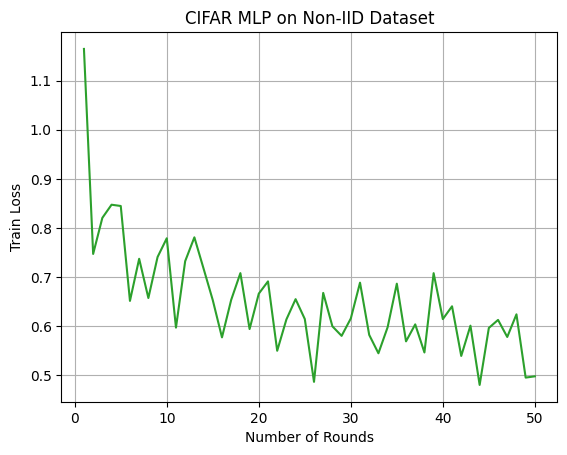

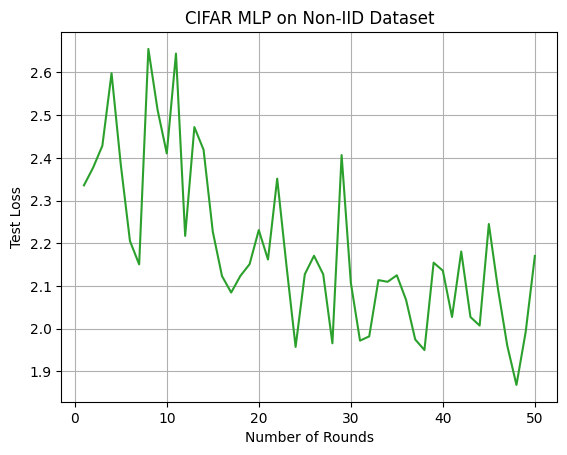

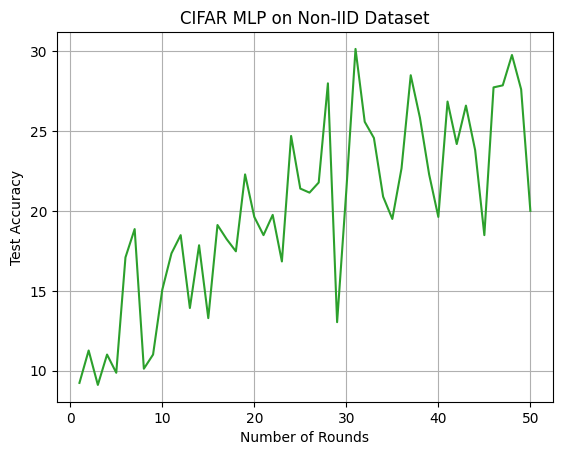

Training Done!
Total time taken to Train: 406.6946792602539


Experiment Run Number:  2
Round: 1... 	Average Loss: 1.075
Round: 2... 	Average Loss: 0.744
Round: 3... 	Average Loss: 0.691
Round: 4... 	Average Loss: 0.681
Round: 5... 	Average Loss: 0.784
Round: 6... 	Average Loss: 0.69
Round: 7... 	Average Loss: 0.675
Round: 8... 	Average Loss: 0.599
Round: 9... 	Average Loss: 0.611
Round: 10... 	Average Loss: 0.7
Round: 11... 	Average Loss: 0.638
Round: 12... 	Average Loss: 0.526
Round: 13... 	Average Loss: 0.533
Round: 14... 	Average Loss: 0.712
Round: 15... 	Average Loss: 0.708
Round: 16... 	Average Loss: 0.753
Round: 17... 	Average Loss: 0.603
Round: 18... 	Average Loss: 0.685
Round: 19... 	Average Loss: 0.566
Round: 20... 	Average Loss: 0.713
Round: 21... 	Average Loss: 0.658
Round: 22... 	Average Loss: 0.604
Round: 23... 	Average Loss: 0.59
Round: 24... 	Average Loss: 0.656
Round: 25... 	Average Loss: 0.71
Round: 26... 	Average Loss: 0.577
Round: 27... 	Average Loss: 0.391
Round: 2

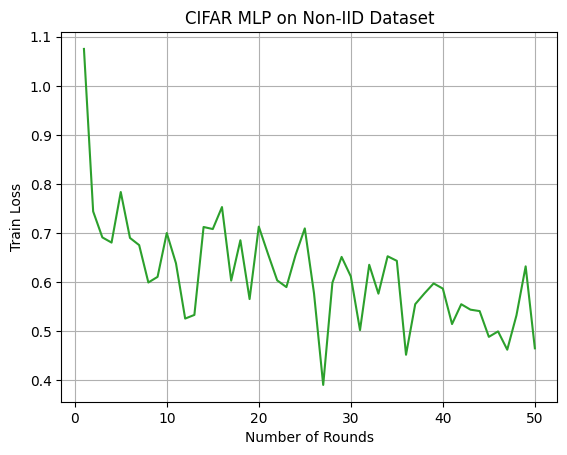

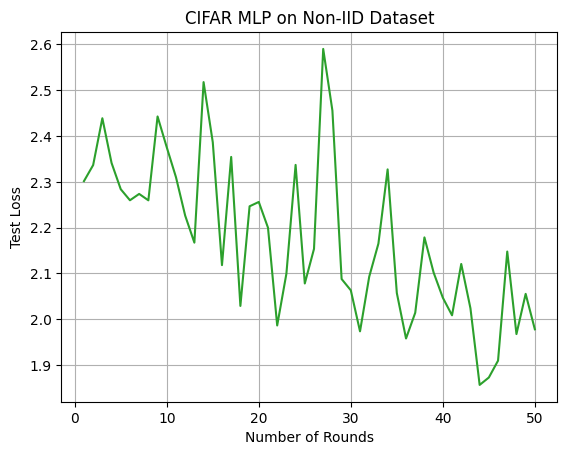

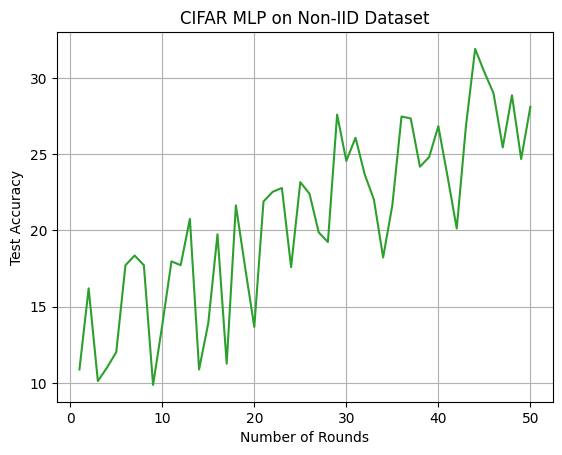

Training Done!
Total time taken to Train: 410.797327041626


Experiment Run Number:  3
Round: 1... 	Average Loss: 1.065
Round: 2... 	Average Loss: 0.724
Round: 3... 	Average Loss: 0.649
Round: 4... 	Average Loss: 0.864
Round: 5... 	Average Loss: 0.796
Round: 6... 	Average Loss: 0.746
Round: 7... 	Average Loss: 0.751
Round: 8... 	Average Loss: 0.607
Round: 9... 	Average Loss: 0.726
Round: 10... 	Average Loss: 0.672
Round: 11... 	Average Loss: 0.651
Round: 12... 	Average Loss: 0.606
Round: 13... 	Average Loss: 0.677
Round: 14... 	Average Loss: 0.559
Round: 15... 	Average Loss: 0.62
Round: 16... 	Average Loss: 0.704
Round: 17... 	Average Loss: 0.666
Round: 18... 	Average Loss: 0.552
Round: 19... 	Average Loss: 0.623
Round: 20... 	Average Loss: 0.576
Round: 21... 	Average Loss: 0.484
Round: 22... 	Average Loss: 0.655
Round: 23... 	Average Loss: 0.495
Round: 24... 	Average Loss: 0.707
Round: 25... 	Average Loss: 0.709
Round: 26... 	Average Loss: 0.55
Round: 27... 	Average Loss: 0.584
Round:

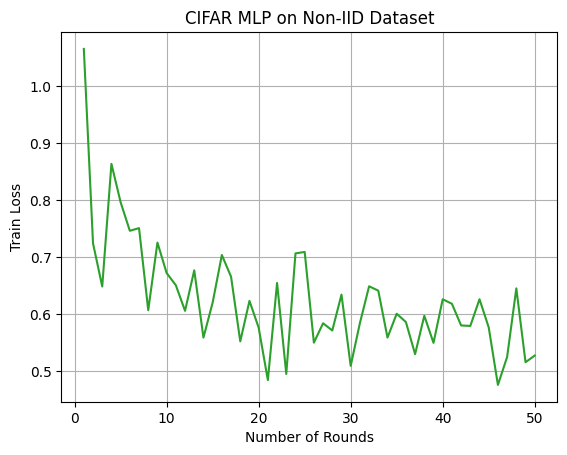

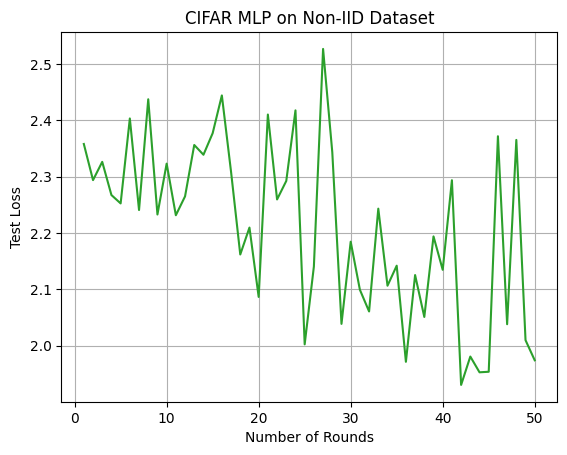

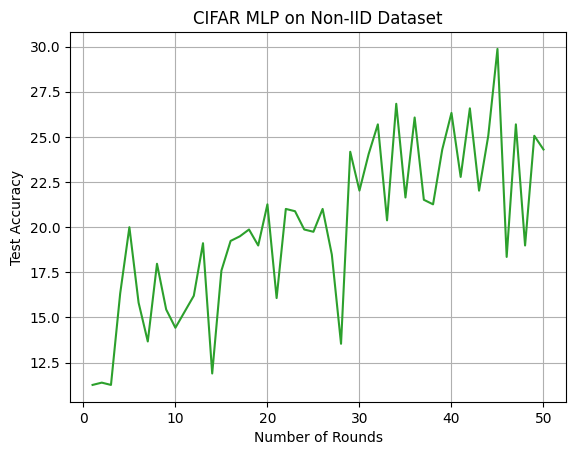

Training Done!
Total time taken to Train: 413.4634621143341


Experiment Run Number:  4
Round: 1... 	Average Loss: 1.164
Round: 2... 	Average Loss: 0.834
Round: 3... 	Average Loss: 0.868
Round: 4... 	Average Loss: 0.826
Round: 5... 	Average Loss: 0.692
Round: 6... 	Average Loss: 0.673
Round: 7... 	Average Loss: 0.717
Round: 8... 	Average Loss: 0.775
Round: 9... 	Average Loss: 0.765
Round: 10... 	Average Loss: 0.749
Round: 11... 	Average Loss: 0.749
Round: 12... 	Average Loss: 0.684
Round: 13... 	Average Loss: 0.731
Round: 14... 	Average Loss: 0.613
Round: 15... 	Average Loss: 0.757
Round: 16... 	Average Loss: 0.598
Round: 17... 	Average Loss: 0.558
Round: 18... 	Average Loss: 0.59
Round: 19... 	Average Loss: 0.633
Round: 20... 	Average Loss: 0.618
Round: 21... 	Average Loss: 0.584
Round: 22... 	Average Loss: 0.696
Round: 23... 	Average Loss: 0.502
Round: 24... 	Average Loss: 0.683
Round: 25... 	Average Loss: 0.564
Round: 26... 	Average Loss: 0.656
Round: 27... 	Average Loss: 0.57
Round

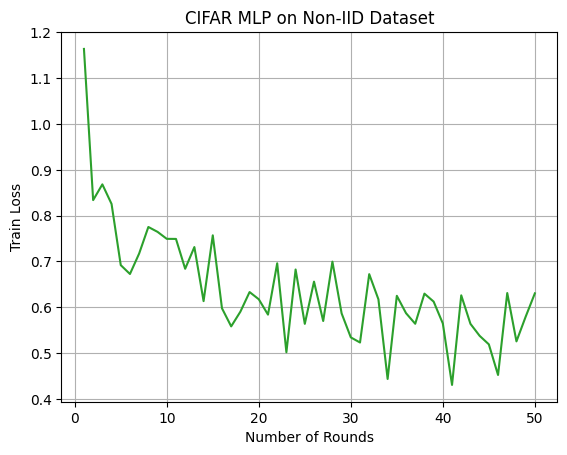

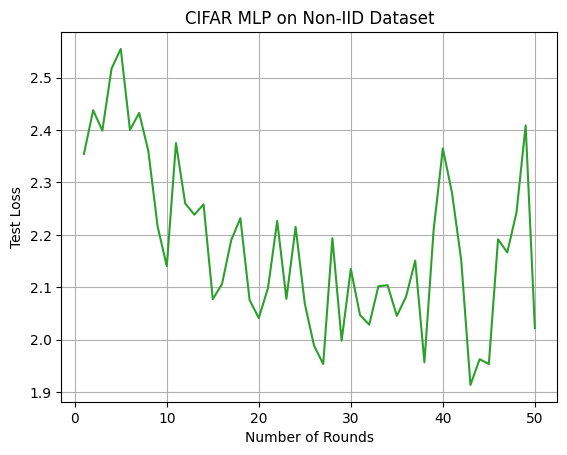

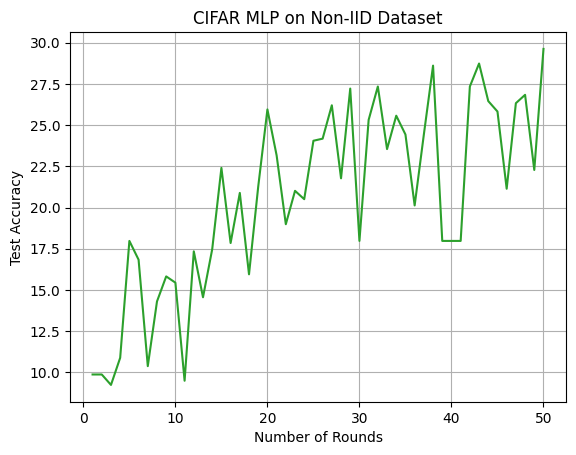

Training Done!
Total time taken to Train: 403.3462724685669




In [27]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(cifar_data_train, 100, 200, 250, 2)
  # load model
  cifar_mlp = CIFAR_MLP()

  if torch.cuda.is_available():
    cifar_mlp.cuda()

  cifar_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_mlp, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, "CIFAR MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [28]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(cifar_mlp_non_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 2.022018

Test Accuracy of     0:  0% ( 0/72)
Test Accuracy of     1:  0% ( 0/78)
Test Accuracy of     2: 54% (47/87)
Test Accuracy of     3:  7% ( 6/80)
Test Accuracy of     4:  0% ( 0/72)
Test Accuracy of     5: 28% (21/73)
Test Accuracy of     6:  0% ( 0/89)
Test Accuracy of     7: 50% (39/78)
Test Accuracy of     8: 60% (52/86)
Test Accuracy of     9: 92% (69/75)

Final Test  Accuracy: 29.620 (234.0/790.0)
